[View in Colaboratory](https://colab.research.google.com/github/MarcinWylot/MultiClassTextClassifier/blob/master/model_NN.ipynb)

In [1]:
!wget https://www.dropbox.com/s/6mfe1c4tjqjn8d4/preprocessed_data.pkl?dl=1
!mv preprocessed_data.pkl?dl=1 preprocessed_data.pkl
!ls -lh 


Redirecting output to ‘wget-log.2’.
total 4.2G
-rw-r--r-- 1 root root 364M Sep 10 13:52 preprocessed_data.pkl
drwxr-xr-x 2 root root 4.0K Sep  6 17:46 sample_data
-rw-r--r-- 1 root root 3.8G Sep 10 13:21 weights-rnn.hdf5
-rw-r--r-- 1 root root  11K Sep 10 12:06 wget-log
-rw-r--r-- 1 root root 5.7K Sep 10 12:11 wget-log.1
-rw-r--r-- 1 root root 5.0K Sep 10 13:52 wget-log.2


In [0]:
import pandas as pd
df = pd.read_pickle("./preprocessed_data.pkl")

In [3]:
df['text'] = df['description'].astype(str) + ' ' + df['html2text']
df.head()

,industry_id,len_description,len_html2text,description,html2text,text
0,0,598,3254,webhostcom offers budget and unlimited web hos...,reliable web hosting services from webhosth fo...,webhostcom offers budget and unlimited web hos...
1,1,323,18637,we are a direct cash advance provider with fun...,abc merchant funding advanced business capital...,we are a direct cash advance provider with fun...
2,2,681,11663,able investigation enforcements are an establi...,able investigations bristol based enforcement ...,able investigation enforcements are an establi...
3,3,1125,1067,for over two decades abm has been known for it...,abm group of companyhome site map client login...,for over two decades abm has been known for it...
4,0,160,12,additionally lets you easily create the best p...,additionally,additionally lets you easily create the best p...


In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'].values)
post_seq = tokenizer.texts_to_sequences(df['text'].values)
post_seq_padded = pad_sequences(post_seq, maxlen=500)


Using TensorFlow backend.


In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=32)
for train_index, test_index in sss.split(post_seq_padded, df["industry_id"]):
    X_train, X_test = post_seq_padded[train_index], post_seq_padded[test_index]
    y_train, y_test = df["industry_id"][train_index], df["industry_id"][test_index]

In [7]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

num_class = len(df["industry_id"].unique())
vocab_size = len(tokenizer.word_index) + 1

inputs = Input(shape=(500, ))
embedding_layer = Embedding(vocab_size,128,input_length=500)(inputs)
x = Flatten()(embedding_layer)
x = Dense(32, activation='relu')(x)

predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()
filepath="weights-nn.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.1, shuffle=True, epochs=5, callbacks=[checkpointer])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 128)          336702592 
_________________________________________________________________
flatten_1 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2048032   
_________________________________________________________________
dense_2 (Dense)              (None, 65)                2145      
Total params: 338,752,769
Trainable params: 338,752,769
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 336702592 elements. This may consume a large amount of memory.
  num_elements)


Train on 26601 samples, validate on 2956 samples
Epoch 1/5
26601/26601 [==============================] - 169s 6ms/step - loss: 3.6961 - acc: 0.1277 - val_loss: 3.2519 - val_acc: 0.2209

Epoch 00001: val_acc improved from -inf to 0.22091, saving model to weights-nn.hdf5
Epoch 2/5
26601/26601 [==============================] - 157s 6ms/step - loss: 1.2830 - acc: 0.7327 - val_loss: 3.2623 - val_acc: 0.2341

Epoch 00002: val_acc improved from 0.22091 to 0.23410, saving model to weights-nn.hdf5
Epoch 3/5
26601/26601 [==============================] - 157s 6ms/step - loss: 0.2680 - acc: 0.9553 - val_loss: 3.3643 - val_acc: 0.2385

Epoch 00003: val_acc improved from 0.23410 to 0.23850, saving model to weights-nn.hdf5
Epoch 4/5
26601/26601 [==============================] - 158s 6ms/step - loss: 0.1419 - acc: 0.9751 - val_loss: 3.4560 - val_acc: 0.2439

Epoch 00004: val_acc improved from 0.23850 to 0.24391, saving model to weights-nn.hdf5
Epoch 5/5
26601/26601 [==============================]

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


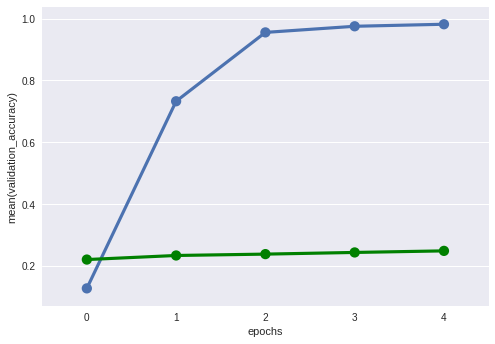

In [8]:
import seaborn as sns
history_df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
g = sns.pointplot(x="epochs", y="accuracy", data=history_df, fit_reg=False)
g = sns.pointplot(x="epochs", y="validation_accuracy", data=history_df, fit_reg=False, color='green')

In [0]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [0]:
import numpy as np
pred_train = np.argmax(pred_train, axis=1)
pred_test = np.argmax(pred_test, axis=1)

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix(pred_train, y_train)

array([[1048,    2,    1, ...,    0,    0,    0],
       [   1,  783,    2, ...,    0,    1,    0],
       [   0,    0,  257, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,  176,    0,    0],
       [   1,    0,    0, ...,    0,  157,    1],
       [   0,    0,    0, ...,    0,    0,  140]])

In [12]:
accuracy_score(y_train, pred_train)

0.9127448658524208

In [13]:
confusion_matrix(pred_test, y_test)

array([[28,  4,  0, ...,  0,  1,  0],
       [ 3, 73,  2, ...,  0,  0,  0],
       [ 0,  0,  3, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  7,  0,  0],
       [ 1,  0,  0, ...,  0,  2,  0],
       [ 0,  0,  0, ...,  0,  0,  1]])

In [14]:
accuracy_score(y_test, pred_test)

0.24343707713125845

In [15]:
from sklearn import metrics
print(metrics.classification_report(y_train, pred_train))
print(metrics.classification_report(y_train, pred_train))

             precision    recall  f1-score   support

          0       0.94      0.90      0.92      1165
          1       0.94      0.93      0.93       844
          2       0.97      0.87      0.92       295
          3       0.82      0.95      0.88      2329
          4       0.98      0.89      0.93       424
          5       0.97      0.91      0.94       395
          6       0.90      0.89      0.90       441
          7       0.85      0.82      0.83       298
          8       0.88      0.93      0.91       461
          9       0.77      0.92      0.84       262
         10       0.98      0.89      0.93       205
         11       0.94      0.93      0.94      1098
         12       0.92      0.94      0.93       464
         13       0.94      0.92      0.93       442
         14       0.95      0.90      0.93       586
         15       0.90      0.91      0.91       756
         16       0.89      0.94      0.91      1932
         17       0.94      0.88      0.91   